# Model comparison to GLODAP along GO-SHIP Easy Ocean lines
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data along the WOCE/GO-SHIP sections. GLODAP data are taken from the cruises used to construct the Easy Ocean lines. Model data are interpolated onto the cruis station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP, and [here](https://cchdo.ucsd.edu/products/goship-easyocean) for information on the Easy Ocean lines.

In [1]:
plotsdir = lambda x="" : "/vortexfs1/home/anthony.meza/scratch/CM4X/figures/" + x


In [2]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy
import cmocean

In [3]:
from geopy import distance


In [4]:
import xesmf as xe
import sectionate

In [5]:
from scipy.interpolate import interp1d
new_z_grid = -1 * np.linspace(10, 6000, 75)
def interpolate_values(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    ds_subset = ds.values[inds]
    where_nonan = (~np.isnan(unique_z)) + (~np.isnan(ds_subset))
    if len(ds_subset[where_nonan]) > 1:
        interp = interp1d(unique_z[where_nonan], ds_subset[where_nonan], 
                          bounds_error = False, kind = "cubic", fill_value=np.nan)
        return interp(new_z_grid)
    else:
        return np.nan * new_z_grid
def interpolate_section(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid

    for key,value in new_ds.items():
        for i in range(len(ds.locations)):
            tmp = interpolate_values(new_ds[key].isel(locations = i), ds_z.isel(locations = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds


In [6]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1'},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035 * 1e3,'cmap':'PuRd','units':'fmolkg-1'},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,35,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(32,37,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

In [7]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='scavenger',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=16)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenger
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.73:41613 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [8]:
def read_CM4X(fname): 
    return xr.open_mfdataset(
        fname,
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        chunks={"latitude":10, "longitude":10, "zl":-1, "year":-1},
        engine="zarr")

def compute_depth_average(ds, zmin, zmax): 
    return ds.sel(zl = slice(zmin, zmax)).mean("zl")

ds = read_CM4X("../CM4Xp25_historical_transient_tracers.zarr")
ds = ds.drop(["lat", "lon"])
ds = ds.rename({"geolat":"lat", "geolon":"lon"})

# # 
#need to interpolate zl to z next 

In [9]:
def time_z_mean(ds, ystart, yend, zmin, zmax):
    ds_tmp = ds.sel(year = slice(ystart, yend)).mean(["year"]).compute()
    ds_mean = ds_tmp.cfc12
    ds_z_mean = ds_tmp.z
    ds_thick_mean = ds_tmp.thkcello
    
    mask = (ds_z_mean > zmin) * (ds_z_mean < zmax)
    weights = mask * ds_thick_mean

    ds_mean_level = (weights * ds_mean).sum("zl") / weights.sum("zl")
    return ds_mean_level * variable_kwargs['cfc12']['conversion']

In [10]:
ds_GLODAPP = xr.open_mfdataset("GLODAP_gridded_CFC.nc")
ds_GLODAPP

<xarray.Dataset>
Dimensions:                        (lon: 180, lat: 90, depth: 79, time: 47)
Coordinates:
  * lon                            (lon) int64 -180 -178 -176 ... 174 176 178
  * lat                            (lat) int64 -90 -88 -86 -84 ... 82 84 86 88
  * depth                          (depth) int64 100 175 250 ... 5800 5875 5950
  * time                           (time) float64 1.972e+03 ... 2.021e+03
Data variables:
    __xarray_dataarray_variable__  (time, depth, lat, lon) float64 dask.array<chunksize=(47, 79, 90, 180), meta=np.ndarray>

In [11]:
cfc_gridded = ds_GLODAPP.__xarray_dataarray_variable__.compute()

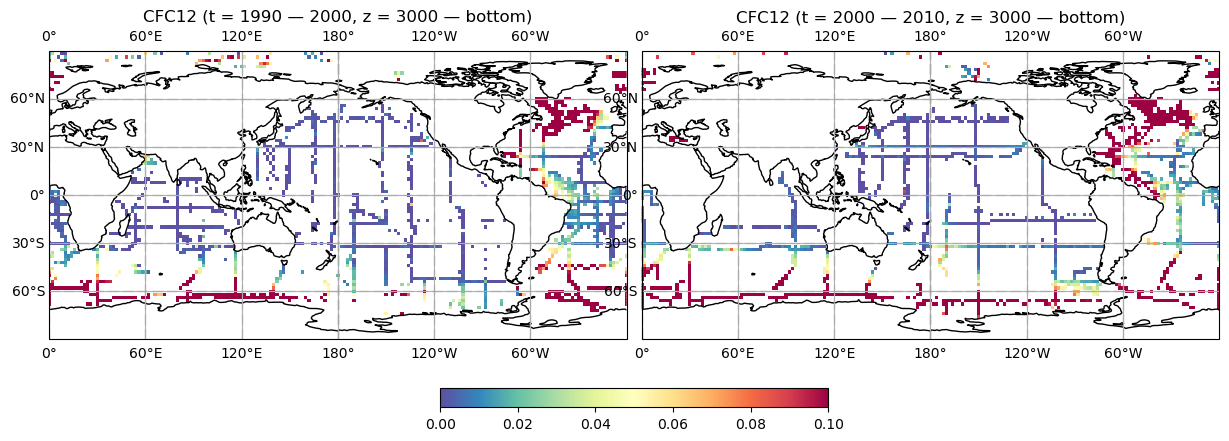

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
# [a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

cfc_gridded.sel(time = slice(1990, 2000), depth = slice(3000, 6000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[0], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())

cm = cfc_gridded.sel(time = slice(2000, 2014), depth = slice(3000, 6000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[1], 
                                                                        vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
# cfc_gridded.sel(time = slice(2010, 2014), depth = slice(3000, 5000)).mean(["time", "depth"]).plot.pcolormesh(ax=axes[2], 
#                                                                                                              vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
#                                                                                                              add_colorbar = False, transform = ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05)

axes[0].set_title("CFC12 (t = 1990 — 2000, z = 3000 — bottom)")
axes[1].set_title("CFC12 (t = 2000 — 2010, z = 3000 — bottom)")
[a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--') for a in axes]
fig.savefig(plotsdir("GLODAPP_planar_view.png"), dpi = 400)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree(central_longitude = 180)})
# [a.set_extent([20, 290, -90, 73], ccrs.PlateCarree()) for a in axes]
[a.gridlines() for a in axes]
[a.coastlines() for a in axes]

time_z_mean(ds, 1990, 2000, -6000, -3000).plot.pcolormesh(ax=axes[0], vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
 
cm = time_z_mean(ds, 2000, 2014, -6000, -3000).plot.pcolormesh(ax=axes[1], vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
                                                                        add_colorbar = False, transform=ccrs.PlateCarree())
# time_z_mean(ds, 2010, 2020, -5000, -3000).plot.pcolormesh(ax=axes[2], vmin = 0, vmax = 0.1, cmap = "Spectral_r", 
#                                                                          add_colorbar = False, transform = ccrs.PlateCarree())
fig.tight_layout()
fig.colorbar(cm, ax = axes[:], orientation = "horizontal", fraction  = 0.02, pad = 0.05)
[a.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.1, linestyle='--') for a in axes]
fig.tight_layout()

axes[0].set_title("CFC12 (t = 1990 — 2000, z = 3000 - bottom)")
axes[1].set_title("CFC12 (t = 2000 — 2010, z = 3000 - bottom)")
fig.savefig(plotsdir("CM4X_planar_view.png"), dpi = 400)

In [ ]:
plot()

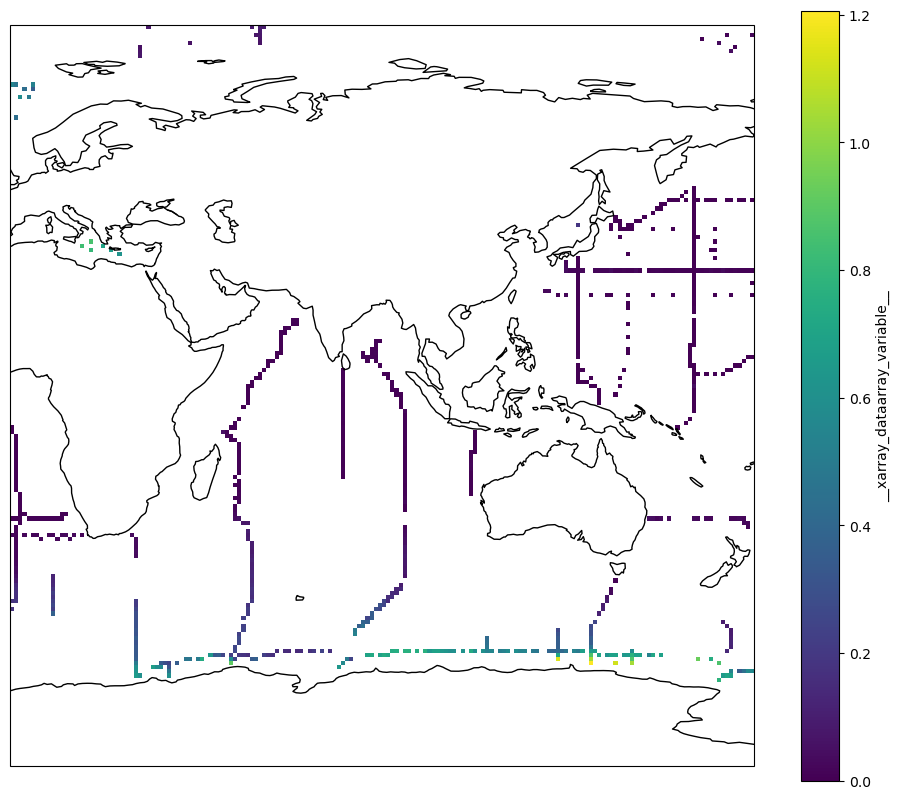

In [42]:
fig, axes = plt.subplots(figsize=(12, 10), subplot_kw={'projection':ccrs.PlateCarree()})

cfc_gridded.sel(lon = slice(0, 180)).sel(time = slice(2010, 2020), depth = slice(3000, 4000)).mean(["time", "depth"]).plot(ax = axes)
axes.coastlines()

In [65]:
ds_locs = xr.Dataset()
ds_locs["lon"] = xr.DataArray(
    data=np.arange(-299, 59), dims=("locations") #need to regrid within model coordinates
)
ds_locs["lat"] = xr.DataArray(data=np.repeat(-30, len(ds_locs["lon"])), dims=("locations"))

In [66]:
regridder = xe.Regridder(ds, ds_locs[["lon", "lat"]], "bilinear", locstream_out=True)
section_dsm = regridder(ds).compute()


In [89]:
len(ds_sections)

156

In [95]:
ds_sections = []
for i in range(len(section_dsm.year)):
    print(i)
    tmp =  1* interpolate_section(section_dsm.isel(year = i).compute())
    ds_sections = ds_sections + [tmp]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164


In [99]:
ds_section = xr.concat(ds_sections, dim = "year")

In [106]:
ds_section.

<xarray.Dataset>
Dimensions:   (year: 165, zl: 75, locations: 358)
Coordinates:
  * year      (year) int64 1850 1850 1850 1850 1850 ... 1850 1850 1850 1850 1850
  * zl        (zl) float64 -10.0 -90.95 -171.9 ... -5.838e+03 -5.919e+03 -6e+03
Dimensions without coordinates: locations
Data variables:
    cfc11     (year, zl, locations) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    cfc12     (year, zl, locations) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    sf6       (year, zl, locations) float32 0.0 0.0 0.0 0.0 ... nan nan nan nan
    so        (year, zl, locations) float32 35.57 35.58 35.58 ... nan nan nan
    thetao    (year, zl, locations) float32 19.8 19.71 19.68 ... nan nan nan
    thkcello  (year, zl, locations) float32 2.001 2.0 2.0 2.0 ... nan nan nan
Attributes:
    regrid_method:  bilinear

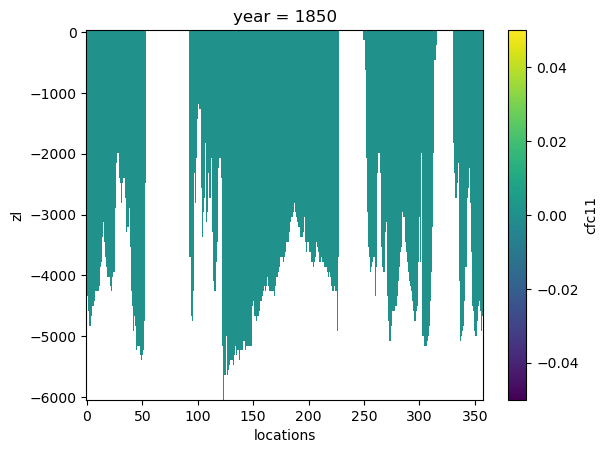

In [105]:
ds_section.isel(year = -1).cfc11.plot()

In [56]:
.mean("year").thetao.plot

<xarray.Dataset>
Dimensions:   (year: 165, zl: 75, locations: 165)
Coordinates:
  * year      (year) int64 1850 1851 1852 1853 1854 ... 2010 2011 2012 2013 2014
  * zl        (zl) float64 1.0 3.0 5.0 7.0 ... 3.338e+03 3.591e+03 5.111e+03
Dimensions without coordinates: locations
Data variables:
    cfc11     (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    cfc12     (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    sf6       (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    so        (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    thetao    (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    thkcello  (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
    z         (year, zl, locations) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    regrid_method:  bilinear

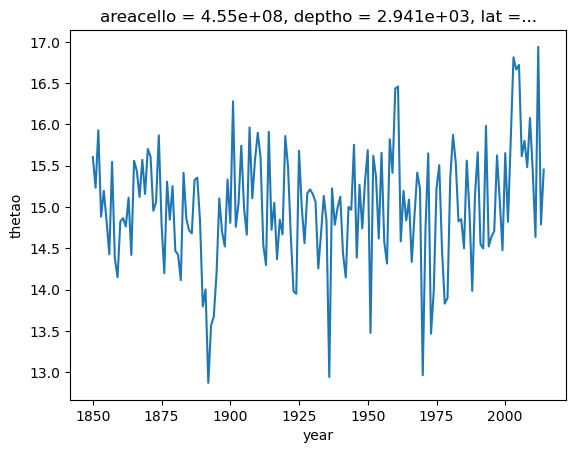

In [40]:
ds.thetao.isel(zl = 0).sel(xh = ds_locs["lon"], yh = ds_locs["lat"], method = "nearest").plot()

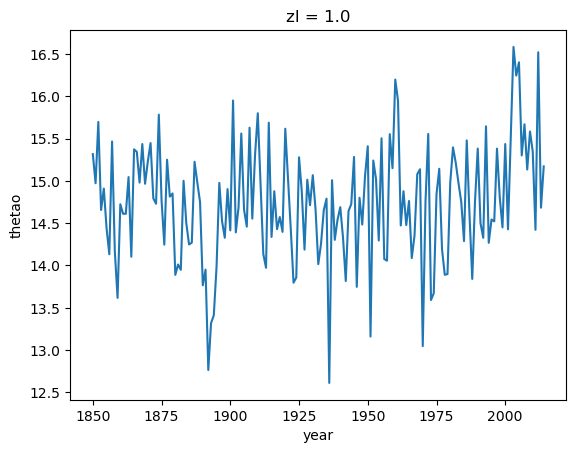

In [41]:
section_dsm.thetao.isel(zl = 0).plot()

In [331]:
sections_dsm = {}
for cruise, section in sections.items():
    regridder = xe.Regridder(ds, sections[cruise][["lon", "lat"]], "bilinear", locstream_out=True)
    section_dsm = regridder(ds)

    print("Cruise #: ", cruise)

    # Apply conversion
    for key,value in variable_kwargs.items():
        if key in section_dsm.keys():
            print(key)
            section_dsm[key] = section_dsm[key]*variable_kwargs[key]['conversion']
    # section_dsm = section_dsm.where(section_dsm.thkcello > 1e-10)
    sections_dsm[cruise] = 1 * section_dsm

Cruise #:  1036.0
cfc12
cfc11
sf6
Cruise #:  1043.0
cfc12
cfc11
sf6
Cruise #:  1044.0
cfc12
cfc11
sf6


In [332]:
new_z_grid = -1 * np.linspace(10, 6000, 75)

In [333]:
from scipy.interpolate import interp1d
def interpolate_values(ds, ds_z):
    unique_z, inds = np.unique(ds_z.values, return_index = True)
    ds_subset = ds.values[inds]
    where_nonan = (~np.isnan(unique_z)) + (~np.isnan(ds_subset))
    if len(ds_subset[where_nonan]) > 1:
        interp = interp1d(unique_z[where_nonan], ds_subset[where_nonan], 
                          bounds_error = False, kind = "cubic", fill_value=np.nan)
        return interp(new_z_grid)
    else:
        return np.nan * new_z_grid
def interpolate_section(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid

    for key,value in new_ds.items():
        print(key)
        for i in range(len(ds.distance)):
            tmp = interpolate_values(new_ds[key].isel(distance = i), ds_z.isel(distance = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds

def interpolate_section_ds(ds):
    ds_z = 1 * ds.z
    new_ds = 1 * ds.drop("z")
    new_ds.coords['zl'] = 1 * new_z_grid

    for key,value in new_ds.items():
        print(key)
        for i in range(len(ds.yh)):
            tmp = interpolate_values(new_ds[key].isel(yh = i), ds_z.isel(yh = i))
            new_ds[key].values[:, i] = tmp
            
    return new_ds

In [334]:
sections_dsmo = {}
for cruise,section_dsm in sections_dsm.items():
    # section_dsmo = section_dsm.drop(['zl'])
    # section_dsmo['depth']=section['depth']
    sections_dsmo[cruise] = 1 * interpolate_section(sections_dsm[cruise].compute())

cfc11
cfc12
sf6
so
thetao
thkcello
cfc11
cfc12
sf6
so
thetao
thkcello
cfc11
cfc12
sf6
so
thetao
thkcello


## Plot section locations

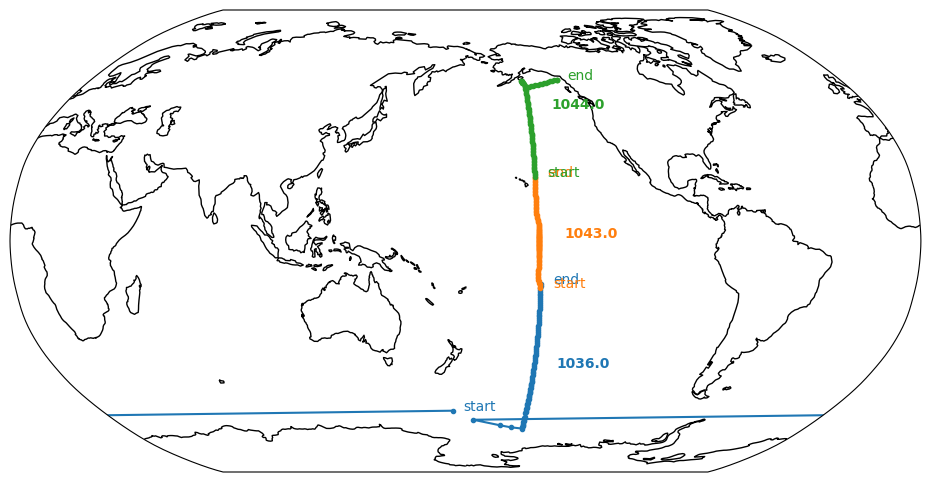

In [335]:
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson(central_longitude = 180)})
ax.set_global()
ax.coastlines()
for cruise,section in sections.items():
    x = section['lon']
    y = section['lat']
    l = ax.plot(x,y,transform=ccrs.PlateCarree(),marker='.')
    color = l[0].get_color()
    ax.text(x[int(len(x)/2)]+10,y[int(len(y)/2)],str(cruise),transform=ccrs.PlateCarree(),color=color,fontweight='bold',horizontalalignment='left')
    ax.text(x[0]+5,y[0],'start',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')
    ax.text(x[-1]+5,y[-1],'end',transform=ccrs.PlateCarree(),color=color,horizontalalignment='left')

## Independent check of P16 interpolation

In [336]:
independent_P16 = ds.sel(xh = -152, method = "nearest").compute()
independent_P16 = interpolate_section_ds(independent_P16)

cfc11
cfc12
sf6
so
thetao
thkcello


## Plot sections of temperature

/tmp/ipykernel_86417/2118053939.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -2, vmax = 20)


Text(0.5, 0.98, 'CM4X Output')

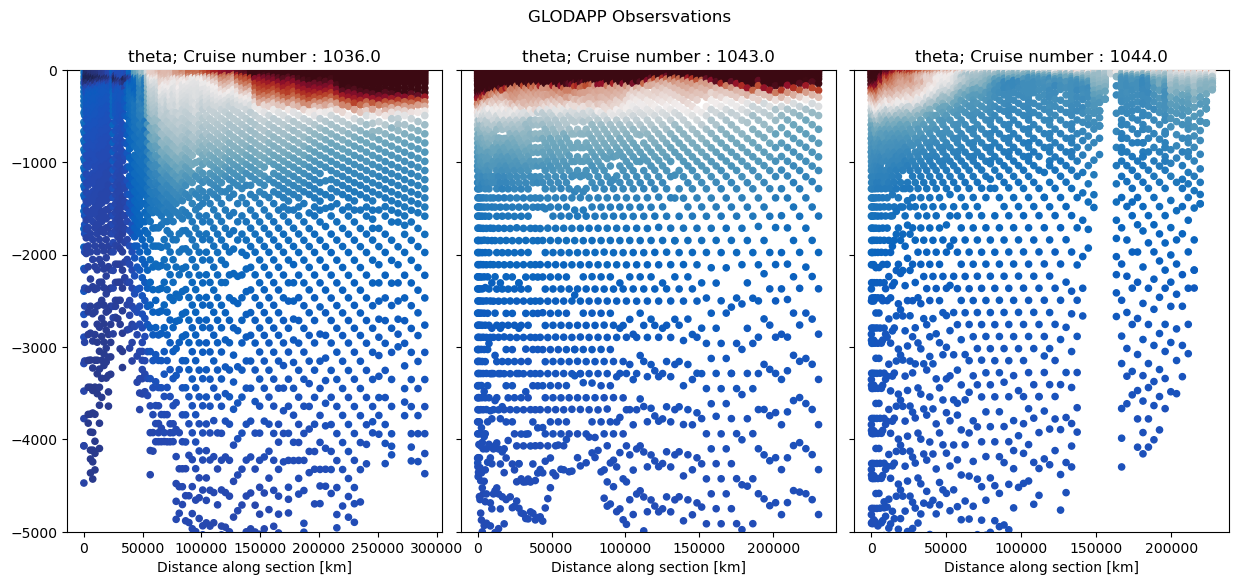

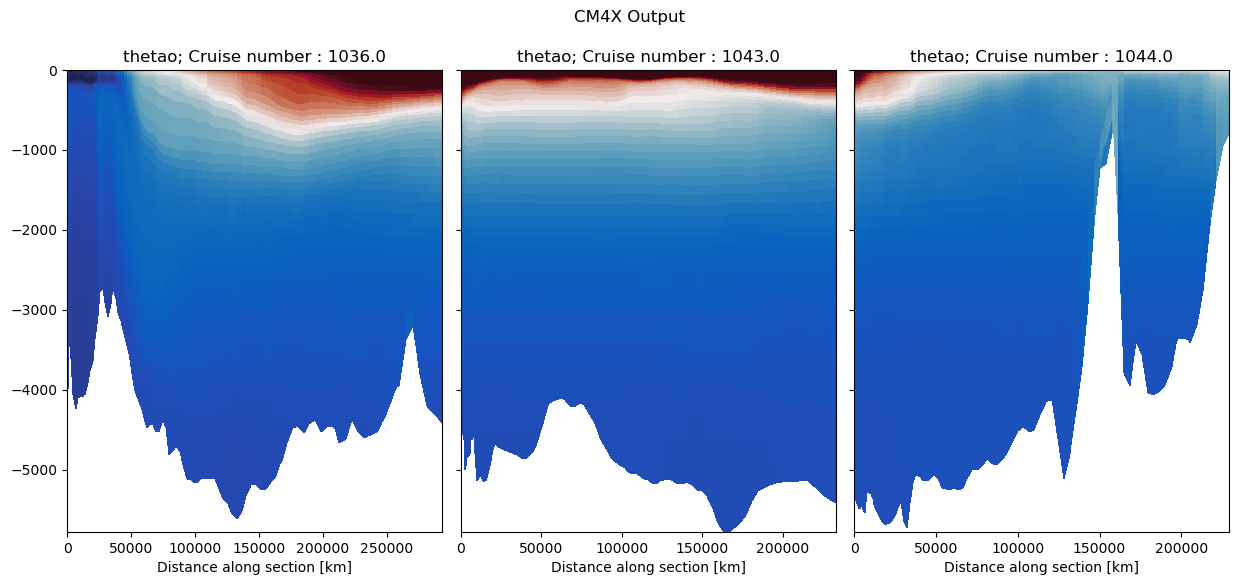

In [337]:
variable = 'theta'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Z[np.abs(Z) > 100] = np.nan
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=20, cmap=cmap,zorder=10, vmin = -2, vmax = 20)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'thetao'
cmap = cmocean.cm.balance
units = "°C"
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = -2, vmax = 20)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")


# variable = 'thetao'
# cmap = cmocean.cm.balance
# units = "°C"
# fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
# for (i, cruise) in enumerate(sections.keys()):
#     ax = axes[i]
#     Z = sections_dsmo[cruise][variable].values
#     im = ax.pcolormesh(sections_dsmo[cruise].distance,sections_dsmo[cruise].zl, Z, cmap=cmap, vmin = -2, vmax = 20)
#     ax.set_xlabel('Distance along section [km]')
#     ax.set_title(variable+'; Cruise number : '+str(cruise))
# fig.subplots_adjust(wspace = 0.05)
# fig.suptitle("CM4X Output Interpolated")

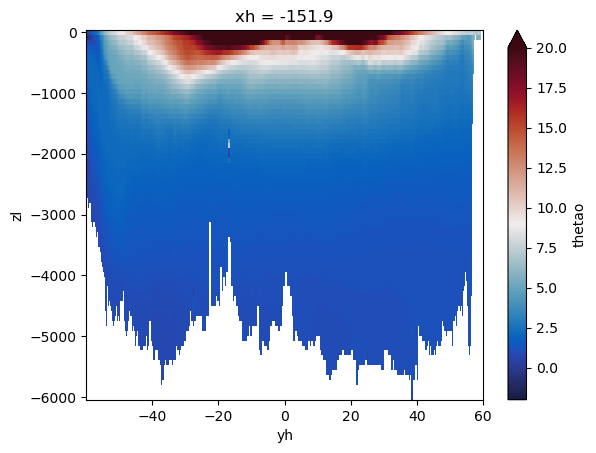

In [338]:
independent_P16.thetao.sel(yh = slice(-60, 60)).plot(cmap=cmap, vmin = -2, vmax = 20)

## Plot sections of CFC12

/tmp/ipykernel_86417/1754403003.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)


Text(0.5, 0.98, 'CM4X Output')

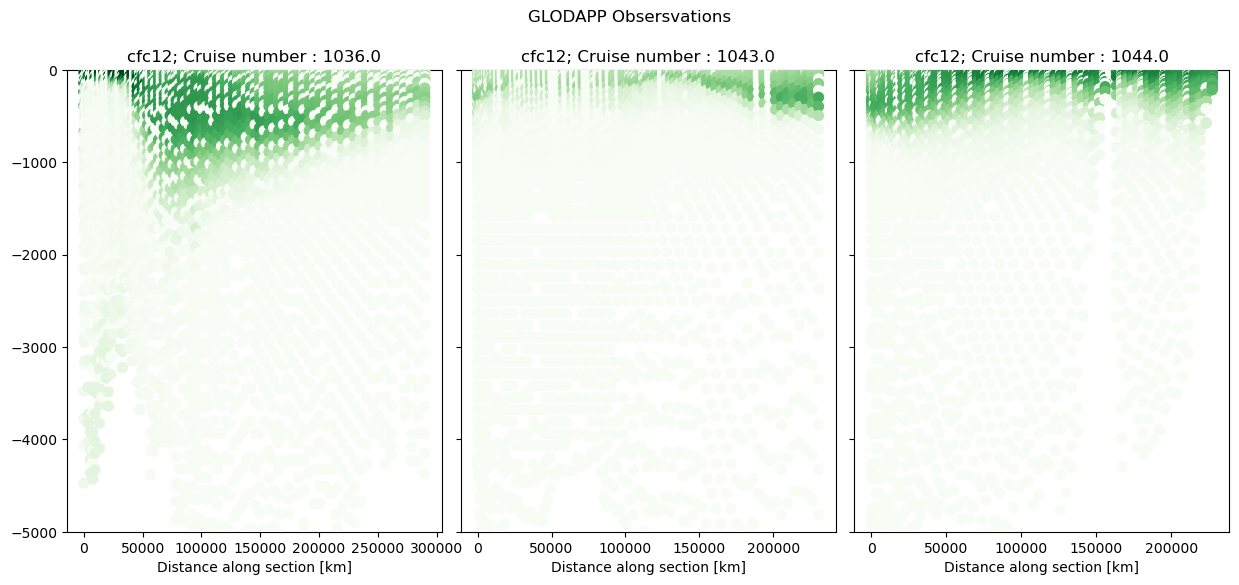

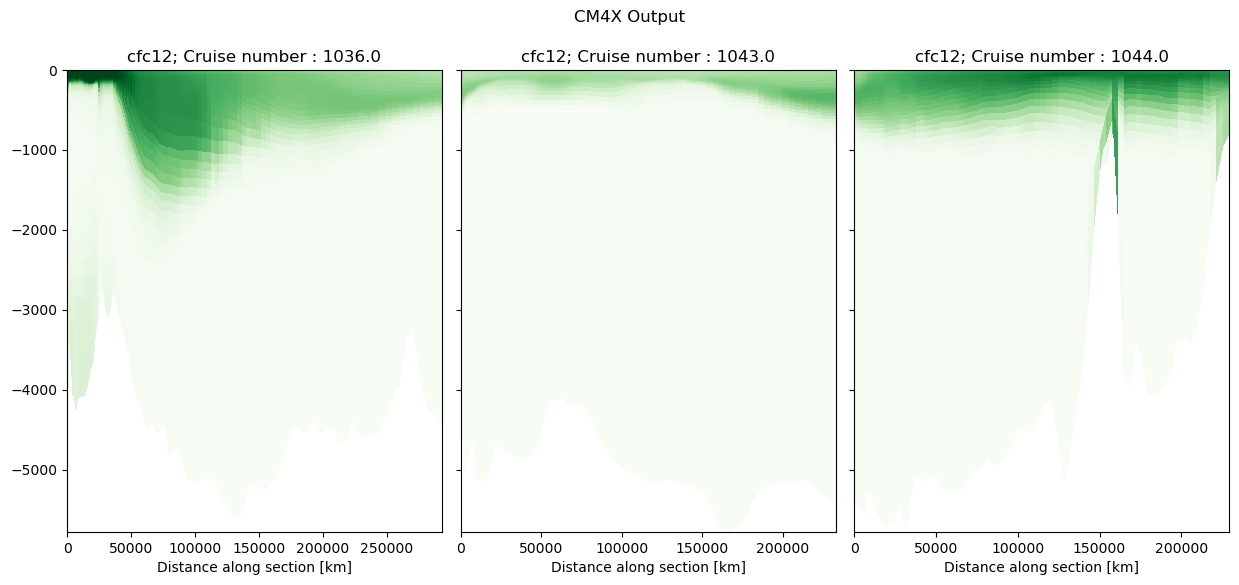

In [339]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

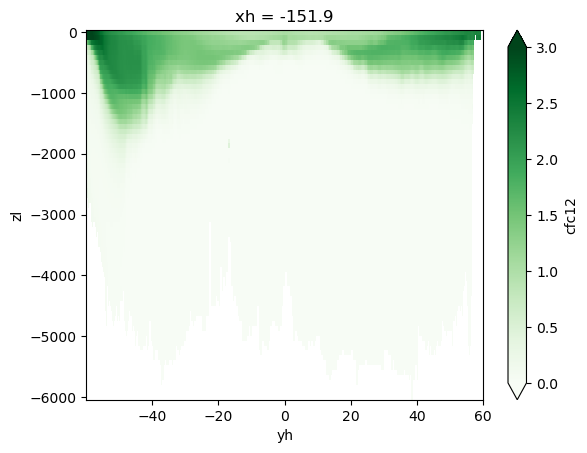

In [340]:
(independent_P16.cfc12 * variable_kwargs["cfc11"]['conversion']).sel(yh = slice(-60, 60)).plot(cmap=cmap, vmin = 0, vmax = 3)

/tmp/ipykernel_86417/1018518787.py:27: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)


Text(0.5, 0.98, 'CM4X Output')

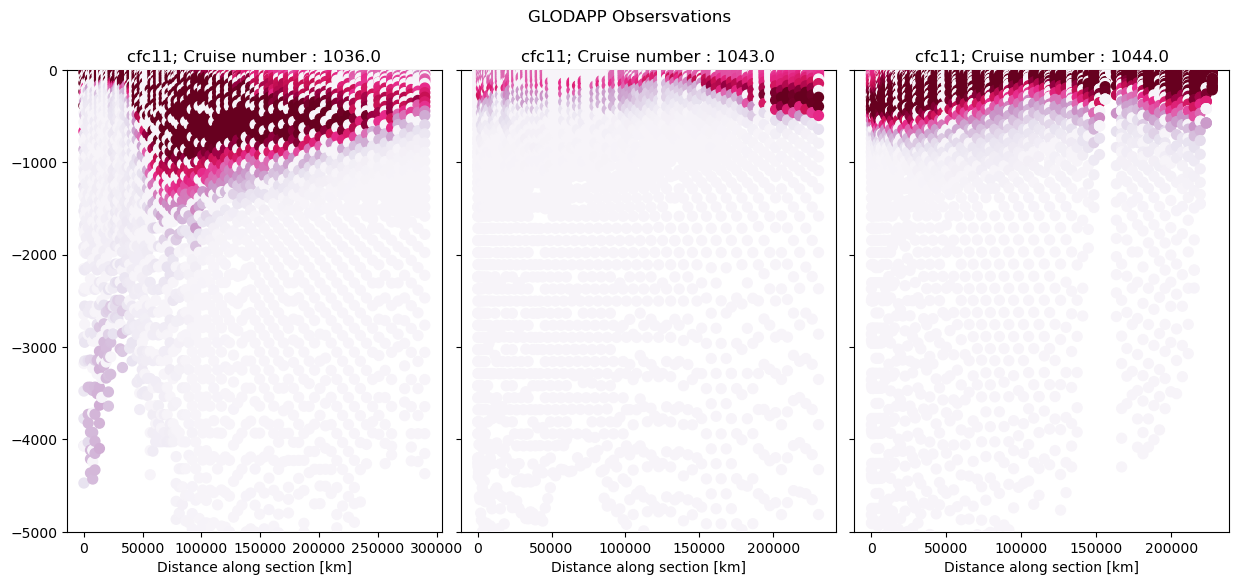

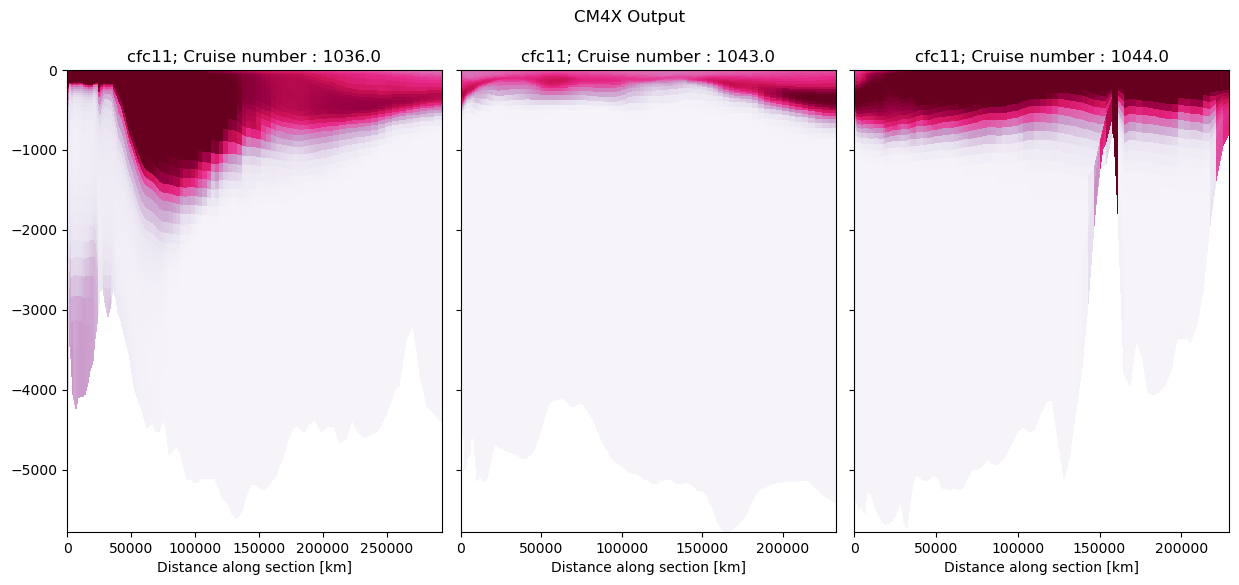

In [341]:
variable = 'cfc11'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")


variable = 'cfc11'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

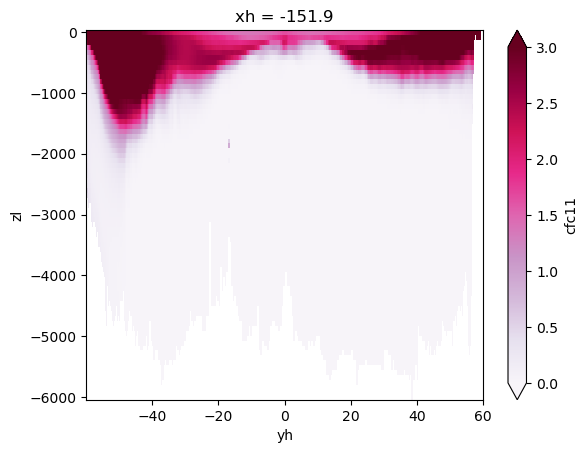

In [342]:
(independent_P16.cfc11 * variable_kwargs["cfc11"]['conversion']).sel(yh = slice(-60, 60)).plot(cmap=cmap, vmin = 0, vmax = 3)

/tmp/ipykernel_86417/3646514157.py:26: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)


Text(0.5, 0.98, 'CM4X Output')

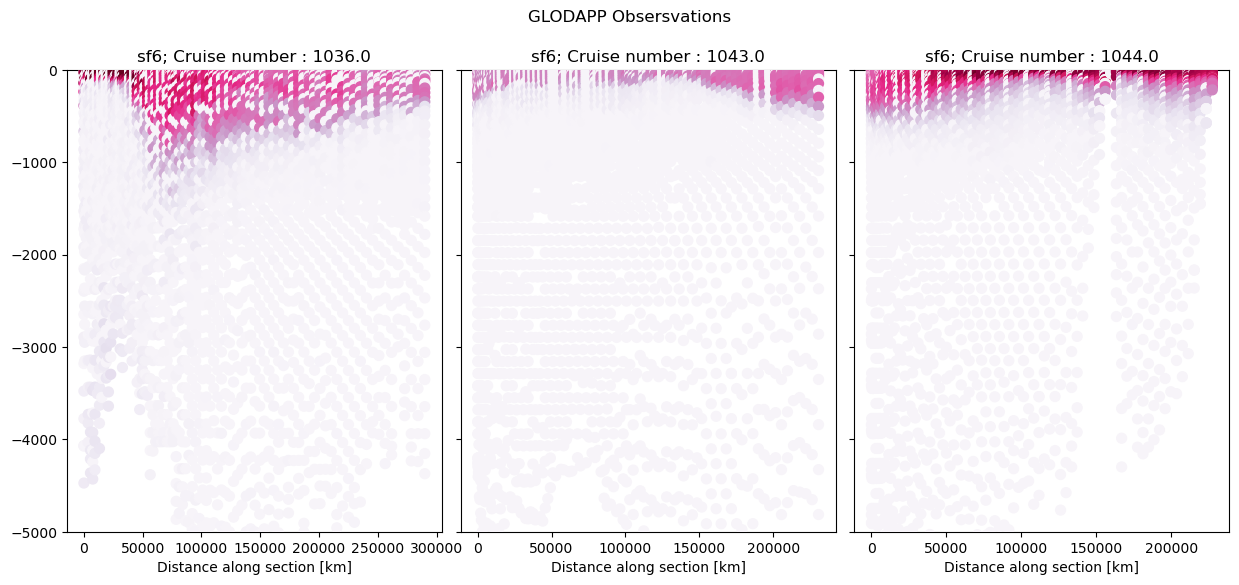

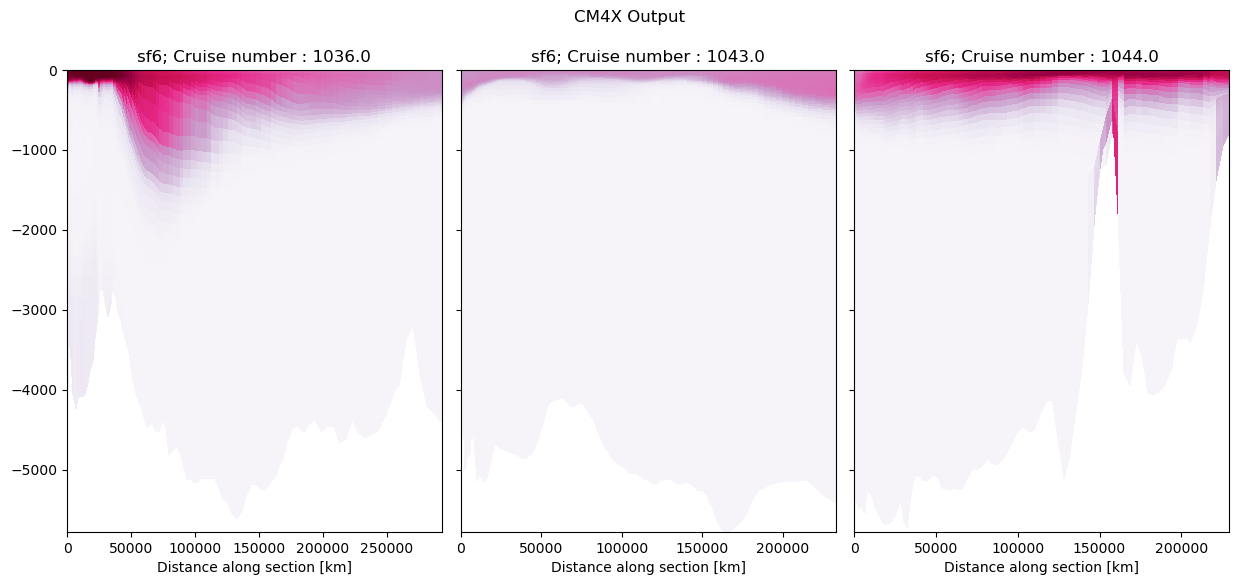

In [343]:
variable = 'sf6'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections[cruise].distance, sections[cruise].n)
    Z = sections[cruise][variable].values
    Y = 1 * sections[cruise].depth.values; Y[np.isnan(Y)] = 10
    im2 = ax.scatter(X.T.flatten(), -Y.flatten(),c = Z.flatten() ,s=50, cmap=cmap,zorder=10, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    ax.set_ylim(-5000, 0)
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("GLODAPP Obsersvations")

variable = 'sf6'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
fig,axes = plt.subplots(1, 3, figsize=(15,6), sharey = True)
for (i, cruise) in enumerate(sections.keys()):
    ax = axes[i]
    X, _ = np.meshgrid(sections_dsm[cruise].distance, sections_dsm[cruise].zl)
    Z = sections_dsm[cruise][variable].values
    Y = 1 * sections_dsm[cruise].z.values; Y[np.isnan(Y)] = 10
    im = ax.pcolormesh(X,Y, Z, cmap=cmap, vmin = 0, vmax = 3)
    ax.set_xlabel('Distance along section [km]')
    ax.set_title(variable+'; Cruise number : '+str(cruise))
fig.subplots_adjust(wspace = 0.05)
fig.suptitle("CM4X Output")

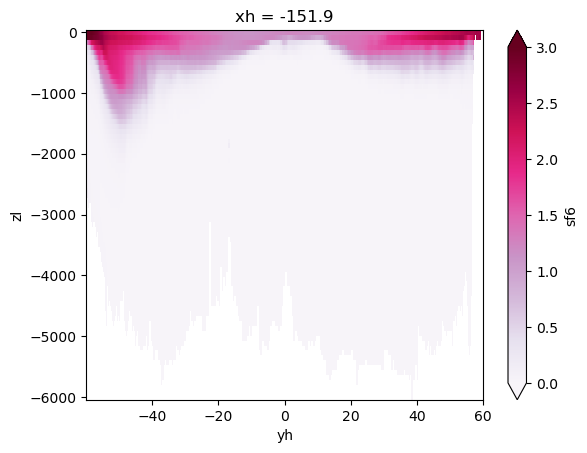

In [344]:
(independent_P16.sf6 * variable_kwargs["sf6"]['conversion']).sel(yh = slice(-60, 60)).plot(cmap=cmap, vmin = 0, vmax = 3)

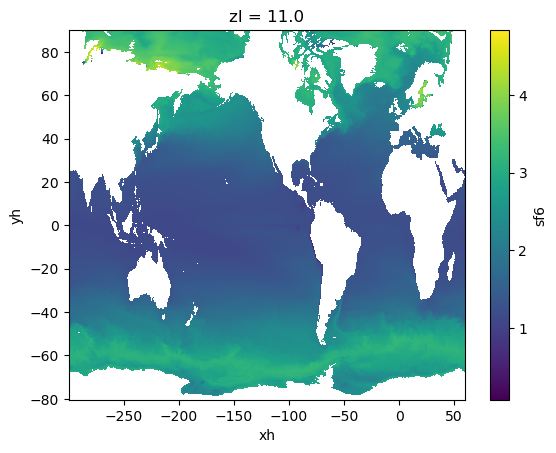

In [345]:
(ds.isel(zl = 5).sf6 * variable_kwargs["sf6"]['conversion']).plot()

### Overlain anomalies

ValueError: 'c' argument has 2700 elements, which is inconsistent with 'x' and 'y' with size 36.

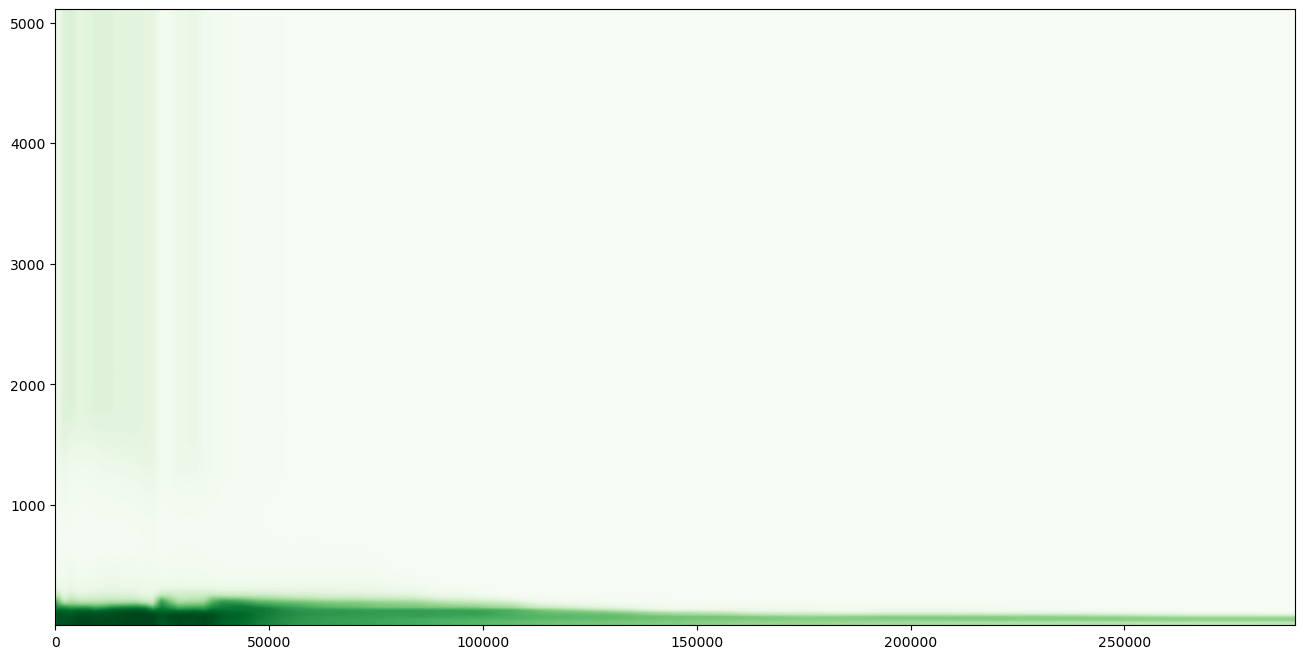

In [48]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
for cruise in sections.keys():
    dsonow = sections[cruise]
    dsmnow = sections_dsm[cruise]
    dsmonow = sections_dsmo[cruise]
    bias = dsmonow - dsonow
    # Replace depth variable
    bias['depth'] = dsonow['depth']
    fig,ax = plt.subplots(figsize=(16,8))
    im1 = ax.contourf(dsmnow['distance'],dsmnow['zl'],dsmnow[variable],100,cmap=cmap)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['theta'],14,colors='tab:purple',alpha=0.5)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['salinity'],14,colors='tab:brown',alpha=0.5)
    im2 = ax.scatter(bias['distance']*xr.ones_like(bias['depth']),bias['depth'],s=15,c=bias[variable],cmap='RdBu_r',zorder=10)
    clims_bias = im2.get_clim()
    cmax = np.max(np.abs(clims_bias))
    im2.set_clim([-1*cmax,cmax])
    ax.set_xlabel('Distance along section [km]')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([6000,0])
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    # Add colorbars
    axc1 = fig.add_axes([0.92,0.2,0.01,0.6])
    cb = fig.colorbar(im1,axc1,orientation='vertical')
    axc2 = fig.add_axes([0.92+0.06,0.2,0.01,0.6])
    cb = fig.colorbar(im2,axc2,orientation='vertical')
    cb.set_label('['+units+']')

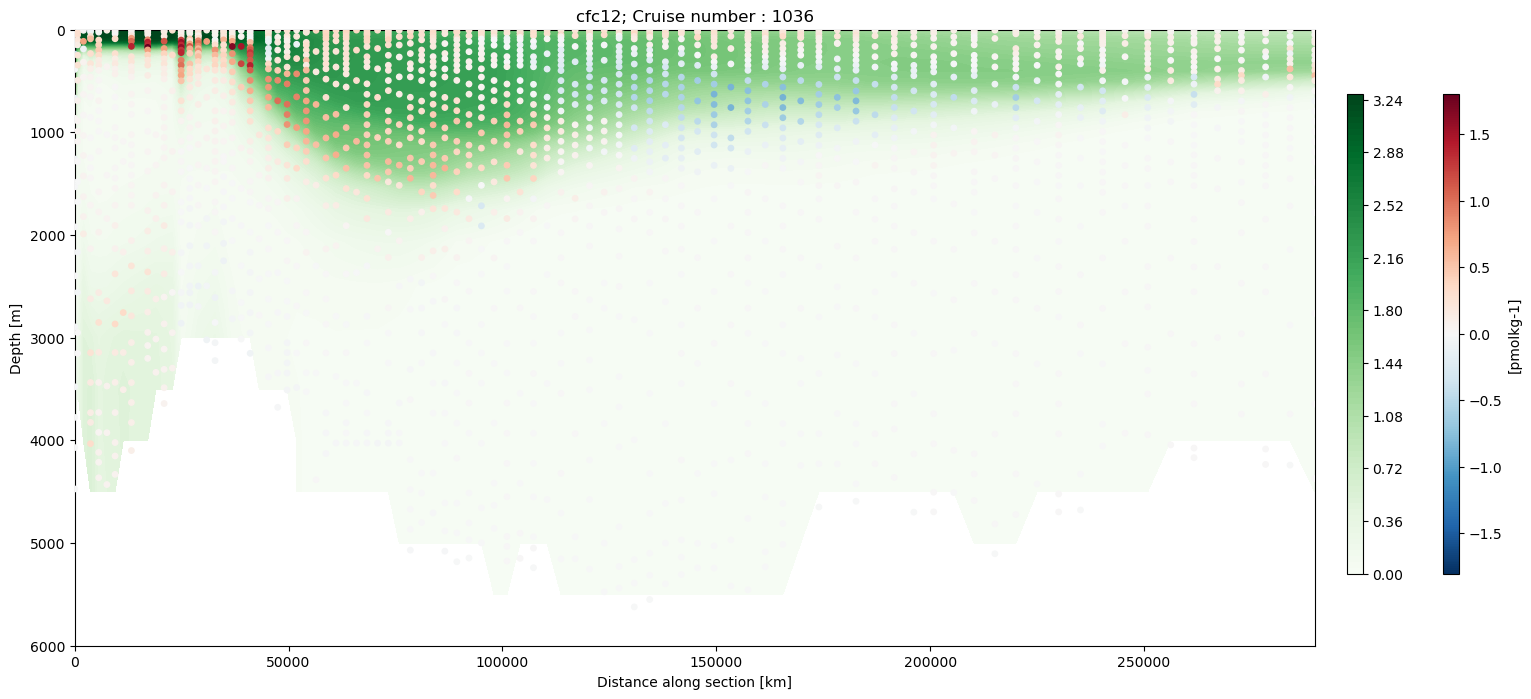

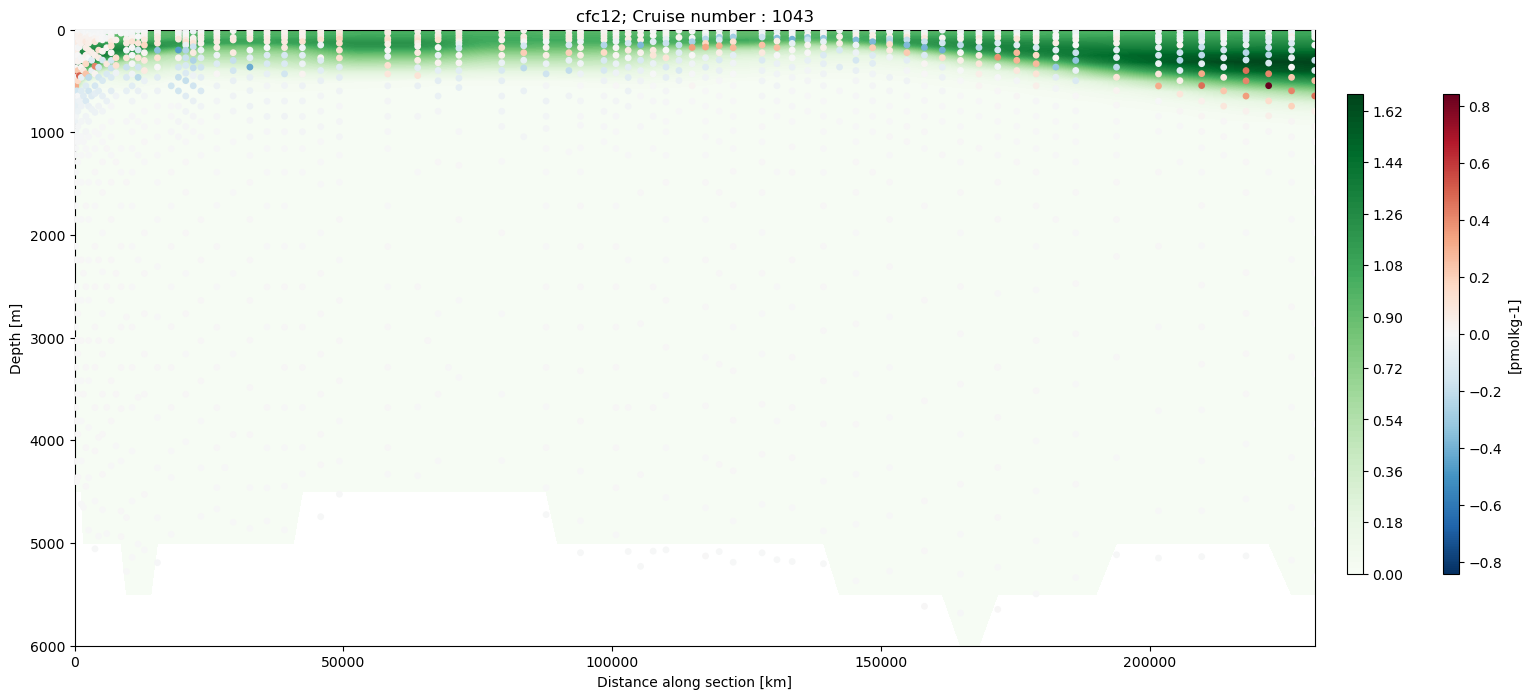

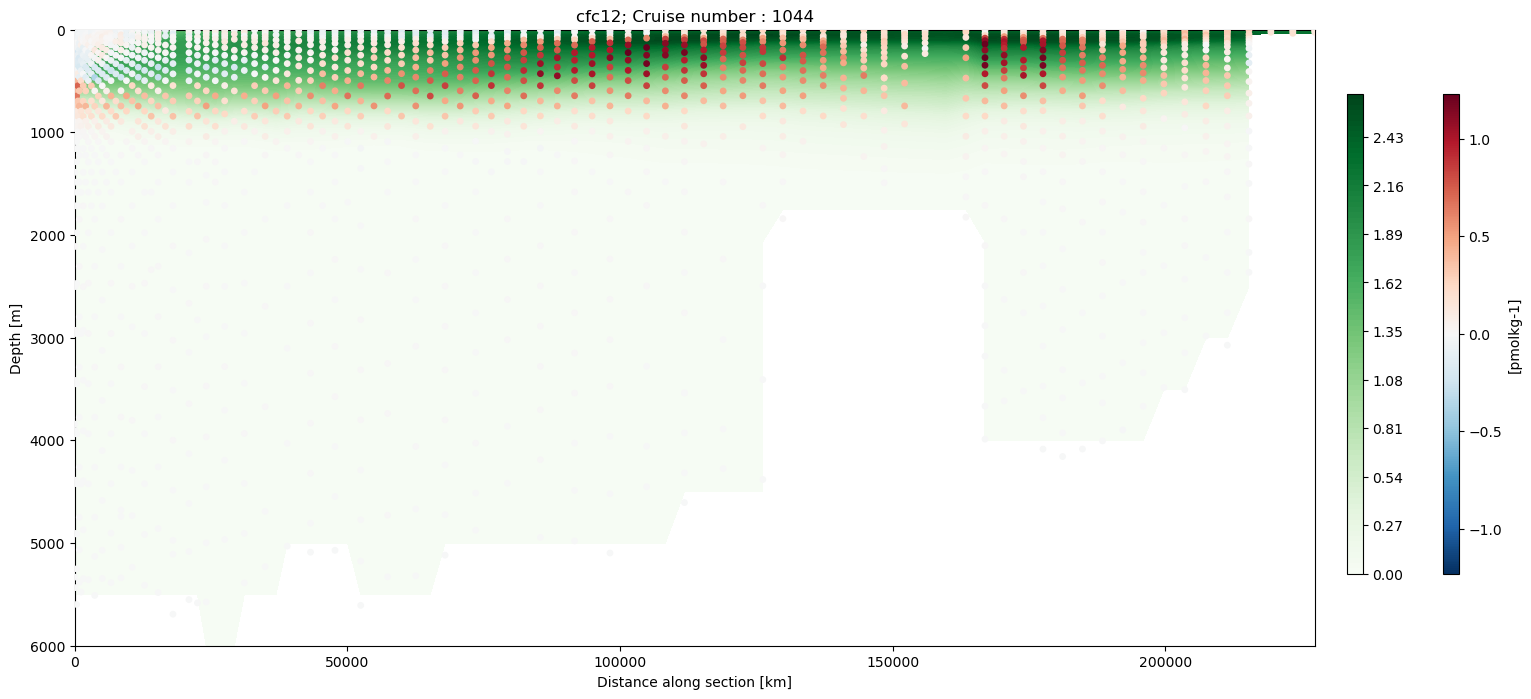

In [503]:
variable = 'cfc12'
cmap = variable_kwargs[variable]['cmap']
units = variable_kwargs[variable]['units']
for cruise in sections.keys():
    dsonow = sections[cruise]
    dsmnow = sections_dsm[cruise]
    dsmonow = sections_dsmo[cruise]
    bias = dsmonow - dsonow
    # Replace depth variable
    bias['depth'] = dsonow['depth']
    fig,ax = plt.subplots(figsize=(16,8))
    im1 = ax.contourf(dsmnow['distance'],dsmnow['z_l'],dsmnow[variable],100,cmap=cmap)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['theta'],14,colors='tab:purple',alpha=0.5)
    # ax.contour(dsmnow['distance'],dsmnow['z_l'],dsmnow['salinity'],14,colors='tab:brown',alpha=0.5)
    im2 = ax.scatter(bias['distance']*xr.ones_like(bias['depth']),bias['depth'],s=15,c=bias[variable],cmap='RdBu_r',zorder=10)
    clims_bias = im2.get_clim()
    cmax = np.max(np.abs(clims_bias))
    im2.set_clim([-1*cmax,cmax])
    ax.set_xlabel('Distance along section [km]')
    ax.set_ylabel('Depth [m]')
    ax.set_ylim([6000,0])
    ax.set_title(variable+'; Cruise number : '+str(cruise))
    # Add colorbars
    axc1 = fig.add_axes([0.92,0.2,0.01,0.6])
    cb = fig.colorbar(im1,axc1,orientation='vertical')
    axc2 = fig.add_axes([0.92+0.06,0.2,0.01,0.6])
    cb = fig.colorbar(im2,axc2,orientation='vertical')
    cb.set_label('['+units+']')

### T-S anomaly space

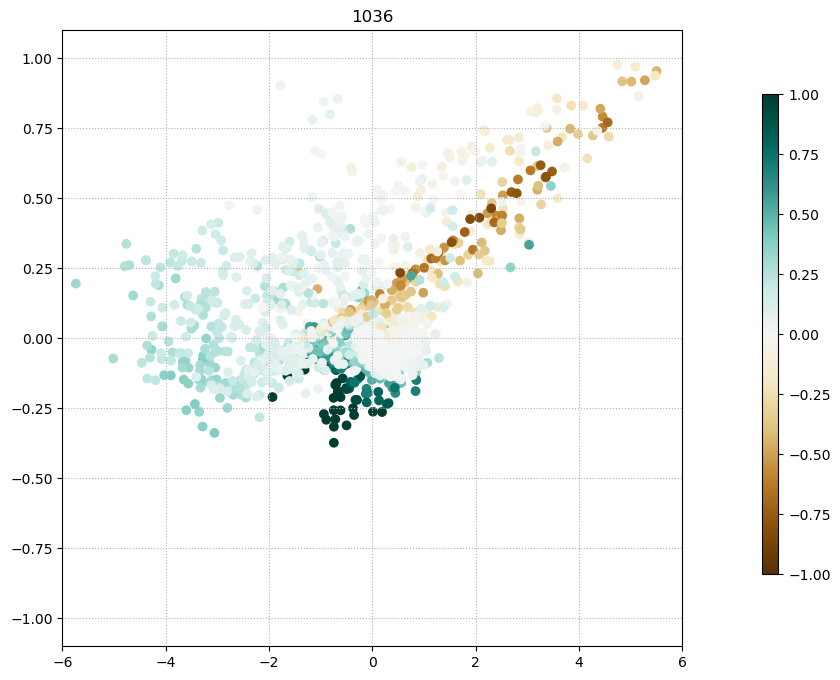

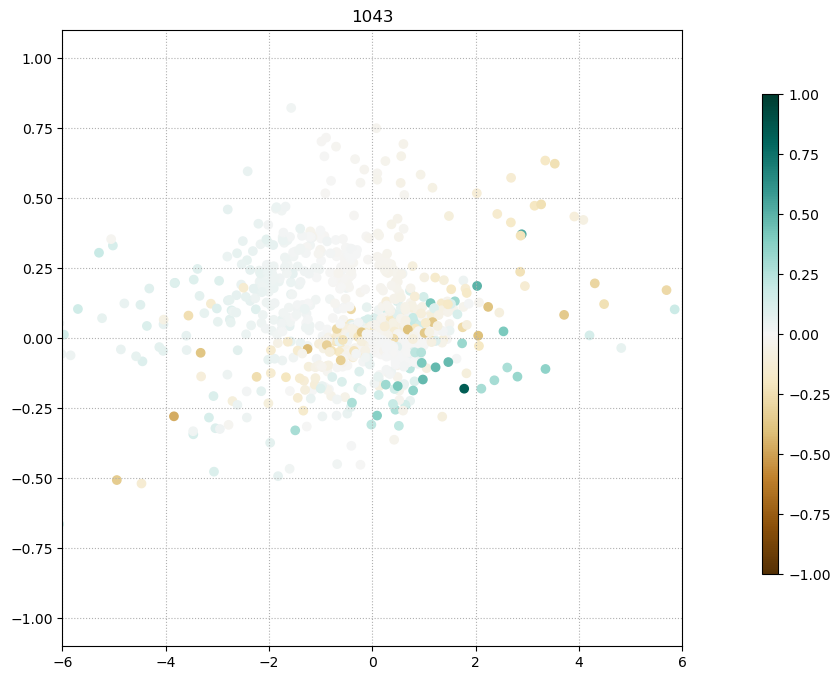

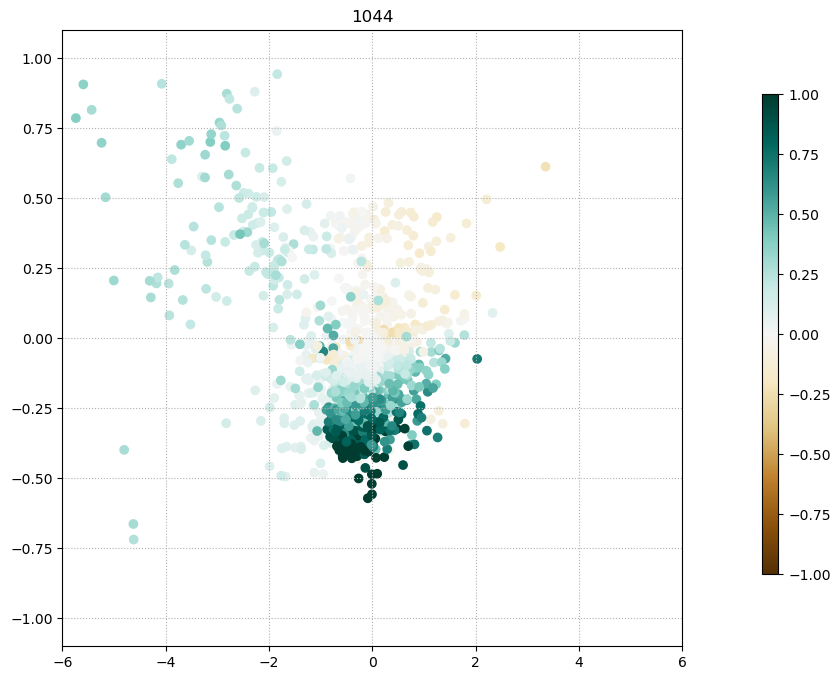

In [504]:
variable = 'cfc12'
for cruise,section in sections.items():
    bias = sections_dsmo[cruise]-section
    fig,ax = plt.subplots(figsize=(8,8))
    ax.grid(linestyle=':')
    im = ax.scatter(bias['theta'],bias['salinity'],c=bias[variable],cmap='BrBG',vmin=-1,vmax=1)
    ax.set_xlim([-6,6])
    ax.set_ylim([-1.1,1.1])
    ax.set_title(cruise)
    cax = fig.add_axes([1, 0.2, 0.02, 0.6])
    fig.colorbar(im, cax, orientation = 'vertical')

### T-S, groups and histograms

In [505]:
dsonow = sections[1036]
dsmonow = sections_dsmo[1036]
bias = dsmonow - dsonow

groupvar = 'theta'
anomaly = True

if anomaly:
    bins = variable_kwargs[groupvar]['anombins']
    dagroup = bias[groupvar]
else:
    bins = variable_kwargs[groupvar]['bins']
    dagroup = dsmonow[groupvar]

gs = {}
g = bias.groupby_bins(dagroup,bins,squeeze=False)
gs['mean'] = g.mean()
gs['std'] = g.std()
bin_centers = [i.mid for i in gs['mean'][groupvar+'_bins'].values]

hs = xr.Dataset()
hs['count'] = histogram(dagroup,bins=[bins],dim=['distance','n'],bin_dim_suffix='_bins')

In [506]:
variable = 'cfc12'

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


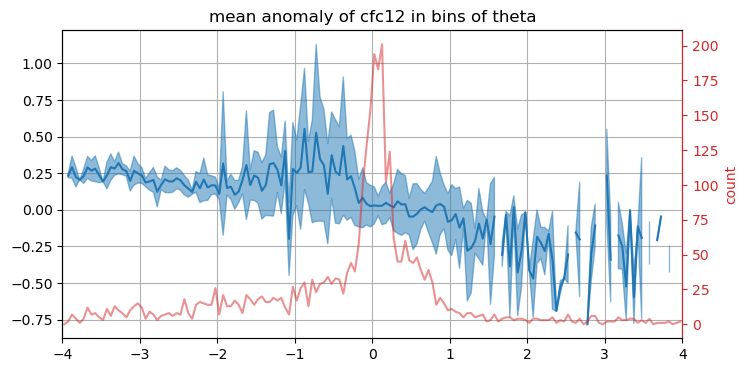

In [507]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(bin_centers,gs['mean'][variable],zorder=10)
ax.fill_between(bin_centers,gs['mean'][variable]-gs['std'][variable],gs['mean'][variable]+gs['std'][variable],color='tab:blue',alpha=0.5,zorder=9)
ax.set_xlim([np.min(bins),np.max(bins)])
ax.set_label(variable_kwargs[groupvar]['units'])
ax.grid()
ax.set_title('mean anomaly of '+variable+' in bins of '+groupvar)
axc = ax.twinx()
im = axc.plot(bin_centers,hs['count'],color='tab:red',alpha=0.5)
axc.set_ylabel('count')
axc.spines['right'].set_color('tab:red')
axc.yaxis.label.set_color('tab:red')
axc.tick_params(axis='y', colors='tab:red')

In [513]:
groupvar1 = 'theta'
groupvar2 = 'salinity'
anomaly = False

if anomaly:
    bins = [variable_kwargs[groupvar1]['anombins'],variable_kwargs[groupvar2]['anombins']]
    dagroup1 = bias[groupvar1]
    dagroup2 = bias[groupvar2]
else:
    bins = [variable_kwargs[groupvar1]['bins'],variable_kwargs[groupvar2]['bins']]
    dagroup1 = dsmonow[groupvar1]
    dagroup2 = dsmonow[groupvar2]

hs = xr.Dataset()
hs['count']=histogram(dagroup1,dagroup2,bins=bins,dim=['distance','n'])
for key,value in bias.items():
    if key=='depth':
        continue
    hs[key+'_sum']=histogram(dagroup1,dagroup2,bins=bins,dim=['distance','n'],weights=value)
    hs[key+'_mean']=hs[key+'_sum']/hs['count']

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


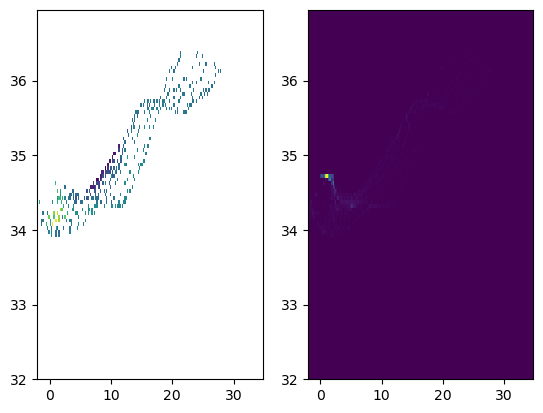

In [514]:
variable = 'cfc12'
fig,ax = plt.subplots(ncols=2)
ax[0].pcolormesh(hs['theta_bin'],hs['salinity_bin'],hs[variable+'_mean'].T,shading='auto')
ax[1].pcolormesh(hs['theta_bin'],hs['salinity_bin'],hs['count'].T,shading='auto')

***
# ARCHIVE

## Interpolate GLODAP data to Easy Ocean line
Options to use a 3D interpolator (`RBFInterpolator`; see [here](https://stackoverflow.com/questions/11214118/3d-extrapolation-in-python-basically-scipy-griddata-extended-to-extrapolate) for example) or the `LocStream` functionality in `xesmf.Regridder` (see [here](https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Comparing_to_section_data.html) for example).

In [186]:
from scipy.interpolate import RBFInterpolator

In [187]:
# Subset only to locations where measurements were made
cond = np.isfinite(dfo['G2cfc12'])
v = dfo[['G2longitude','G2latitude','G2depth']][cond].to_numpy()
d = dfo['G2cfc12'][cond].values

xi, yi, zi = np.meshgrid(dso_nc['longitude'].values,
                         dso_nc['latitude'].values,
                         dso_nc['pressure'].values)
vi = np.vstack((xi.ravel(), yi.ravel(), zi.ravel())).transpose()

rbf = RBFInterpolator(v, d, kernel="thin_plate_spline",smoothing=1000)
di = rbf(vi)

di = di.reshape(xi.shape)
tmp = dso_nc['temperature'].isel(gridded_section=0).squeeze()
dsg = xr.Dataset()
dsg['cfc12'] = tmp.copy(data=di.squeeze().transpose()).where(np.isfinite(tmp))

## Interpolate model data to Easy Ocean line

In [188]:
dsmo = dsm.interp({'lat':dso_nc['latitude'],'lon':dso_nc['longitude'],'z_l':dso_nc['pressure']}).squeeze()

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


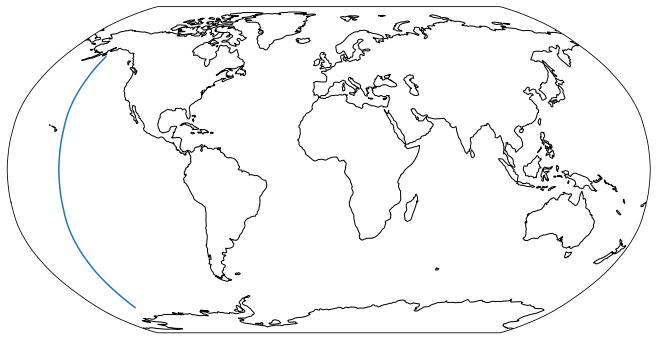

In [189]:
if dimx=='longitude':
    x=dso_nc['longitude'].values
    y=dso_nc['latitude']*xr.ones_like(dso_nc['longitude']).squeeze().values
elif dimx=='latitude':
    x=dso_nc['longitude']*xr.ones_like(dso_nc['latitude']).squeeze().values
    y=dso_nc['latitude'].values
    
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.plot(x,y,transform=ccrs.PlateCarree())
ax.coastlines()

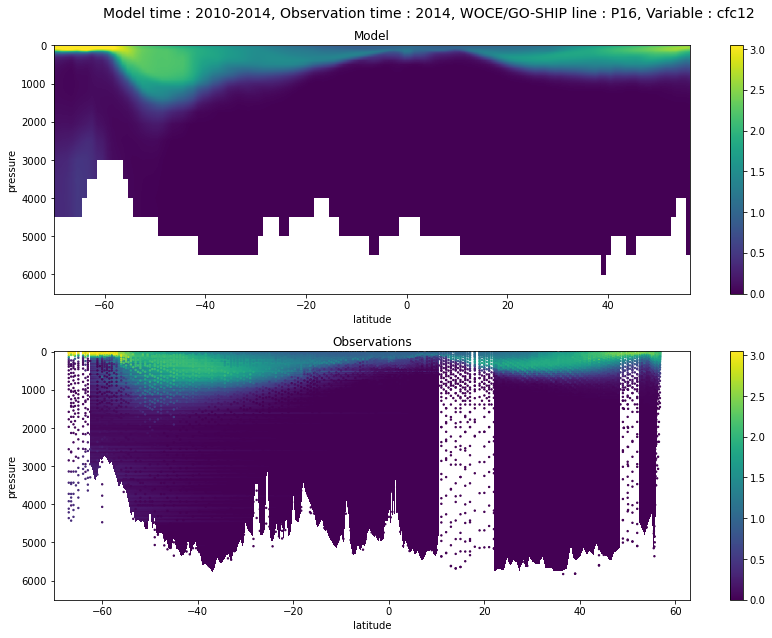

In [196]:
variable = 'cfc12'
conversion = 1e12/1035
x = dsg[dimx]
y = dsg['pressure']
zo = dsg[variable]
zm = dsmo[variable]*conversion

fig,ax = plt.subplots(figsize=(12,9),nrows=2)

fig.suptitle('Model time : '+time+
              ', Observation time : '+str(yearo)+
              ', WOCE/GO-SHIP line : '+line+
              ', Variable : '+variable,
            fontsize=14)

im = ax[0].pcolormesh(x,y,zm,shading='auto')
ax[0].invert_yaxis()
ax[0].set_title('Model')
ax[0].set_xlabel(dimx)
ax[0].set_ylabel('pressure')
plt.colorbar(im,ax=ax[0])

imp = ax[1].pcolormesh(x,y,zo,shading='auto')
ax[1].invert_yaxis()
# Add original observations
ims = ax[1].scatter(v[:,1],v[:,2],c=d,s=2)
clims = list(imp.get_clim())
clims[0]=0
imp.set_clim(clims)
ims.set_clim(clims)
im.set_clim(clims) # Set model lims to obs
ax[1].set_title('Observations')
ax[1].set_xlabel(dimx)
ax[1].set_ylabel('pressure')
plt.colorbar(imp,ax=ax[1])

fig.tight_layout()